In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import altair as alt

## Load Data

In [2]:
data=pd.read_csv('EcomerceData.csv')

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.39,17850.0,United Kingdom


## Data preprocessing

### Convering date into datetime 

In [4]:
data['InvoiceDate']= pd.to_datetime(data['InvoiceDate'], format='mixed') 

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


### Calculating Total spending

In [6]:
data['Spending'] = (data['Quantity'] * data['UnitPrice'])

### Remove minues from Spending

In [7]:
data = data[data['Spending'] >= 0]

In [8]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Spending
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## RFM Analysis

### Calculating Maximum date

In [9]:
max_date= data['InvoiceDate'].max()

### Calculate Recency

In [10]:
rfm= data.groupby('CustomerID')['InvoiceDate'].max().reset_index(name='LastPurchaseDate')
rfm['Recency'] = (max_date - rfm['LastPurchaseDate']).dt.days

### Calculate Frequency

In [11]:
rfm['Frequency']= data.groupby('CustomerID')['CustomerID'].count().reset_index(name='Frequency')['Frequency']

### Calculate Monetary Value

In [12]:
rfm['Monetary'] = data.groupby('CustomerID')['Spending'].sum().reset_index(name='Monetary')['Monetary']

In [13]:
rfm.head()

,CustomerID,LastPurchaseDate,Recency,Frequency,Monetary
0,12346.0,2011-01-18 10:01:00,325,1,77183.60
1,12347.0,2011-12-07 15:52:00,1,182,4310.00
2,12348.0,2011-09-25 13:13:00,74,31,1797.24
3,12349.0,2011-11-21 09:51:00,18,73,1757.55
4,12350.0,2011-02-02 16:01:00,309,17,334.40


## RFM segmentation

### Create quartiles for each metrics

In [14]:
quantiles= rfm.quantile(q=[0.25,0.5,0.75])
quantiles= quantiles.to_dict()

### Create RFM score

In [26]:
def rfm_score(x):
    r_score = 4
    f_score = 4
    m_score = 4
    if x['Recency'] <= quantiles['Recency'][0.25]:
        r_score = 1
    elif x['Recency'] <= quantiles['Recency'][0.5]:
        r_score = 2
    elif x['Recency'] <= quantiles['Recency'][0.75]:
        r_score = 3
    if x['Frequency'] <= quantiles['Frequency'][0.25]:
        f_score = 1
    elif x['Frequency'] <= quantiles['Frequency'][0.5]:
        f_score = 2
    elif x['Frequency'] <= quantiles['Frequency'][0.75]:
        f_score = 3
    if x['Monetary'] <= quantiles['Monetary'][0.25]:
        m_score = 1
    elif x['Monetary'] <= quantiles['Monetary'][0.5]:
        m_score = 2
    elif x['Monetary'] <= quantiles['Monetary'][0.75]:
        m_score = 3
    return str(r_score) + str(f_score) + str(m_score)

In [27]:
rfm['RFM_score']= rfm.apply(rfm_score, axis=1)

In [28]:
rfm.head()

,CustomerID,LastPurchaseDate,Recency,Frequency,Monetary,RFM_score,Segment
0,12346.0,2011-01-18 10:01:00,325,1,77183.60,414,At-Risk
1,12347.0,2011-12-07 15:52:00,1,182,4310.00,144,At-Risk
2,12348.0,2011-09-25 13:13:00,74,31,1797.24,324,At-Risk
3,12349.0,2011-11-21 09:51:00,18,73,1757.55,234,At-Risk
4,12350.0,2011-02-02 16:01:00,309,17,334.40,412,At-Risk


## Customer Segmentation

### Segment customers based on RFM score

In [29]:
def rfm_segment(score):
    if score >= 333:
        return 'Champions'
    elif score >= 222:
        return 'Loyal'
    elif score >= 144:
        return 'Potential'
    elif score == 132:
        return 'New Customers'
    else:
        return 'At-Risk'

In [34]:
rfm['RFM_score']=rfm['RFM_score'].astype(int)

In [35]:
rfm['Segment']=rfm['RFM_score'].apply(rfm_segment)

In [36]:
rfm.head()

,CustomerID,LastPurchaseDate,Recency,Frequency,Monetary,RFM_score,Segment
0,12346.0,2011-01-18 10:01:00,325,1,77183.60,414,Champions
1,12347.0,2011-12-07 15:52:00,1,182,4310.00,144,Potential
2,12348.0,2011-09-25 13:13:00,74,31,1797.24,324,Loyal
3,12349.0,2011-11-21 09:51:00,18,73,1757.55,234,Loyal
4,12350.0,2011-02-02 16:01:00,309,17,334.40,412,Champions


### Visualizing customer segments

Segment
Loyal            1522
Champions        1459
Potential         679
At-Risk           634
New Customers      45
Name: count, dtype: int64


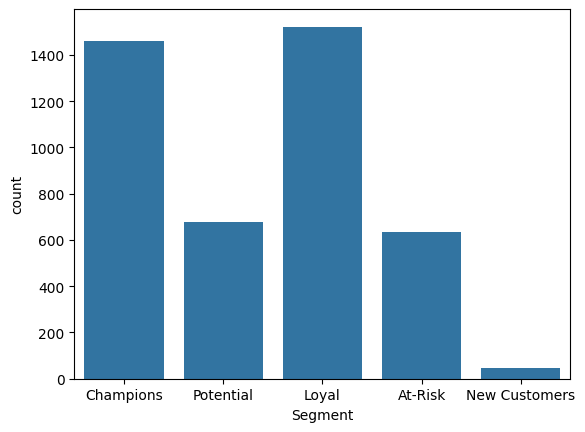

In [40]:
value_counts = rfm['Segment'].value_counts()
print(value_counts)
sns.countplot(x='Segment', data=rfm)
plt.show()

### Potential Insights:
- **Customer Base:** The majority of your customer base falls into the "Loyal" and "Champions" categories, indicating a strong customer retention strategy.
- **Customer Acquisition:** There's a relatively small number of "New Customers," suggesting potential areas for improvement in customer acquisition efforts.

## Risk Customer analysis based on RFM segments

In [41]:
risk_customer_df= rfm[rfm['Segment']=='At-Risk']
risk_customer_df.head()

,CustomerID,LastPurchaseDate,Recency,Frequency,Monetary,RFM_score,Segment
11,12358.0,2011-12-08 10:26:00,1,19,1168.06,123,At-Risk
17,12364.0,2011-12-02 10:22:00,7,85,1313.10,133,At-Risk
19,12367.0,2011-12-05 16:48:00,3,11,168.90,111,At-Risk
25,12375.0,2011-11-29 10:36:00,10,17,457.50,112,At-Risk
30,12381.0,2011-12-05 12:44:00,4,87,1845.31,134,At-Risk


In [42]:
total_customers=rfm.shape[0]
total_risk_customer=risk_customer_df.shape[0]
percentage=(risk_customer_df.shape[0]/rfm.shape[0]*100)

print(f'Total number of customers: {total_customers}')
print(f'Total customers at risk: {total_risk_customer}')
print(f'Percent of customer at risk: {percentage}%')

Total number of customers: 4339
Total customers at risk: 634
Percent of customer at risk: 14.611661673196588%


## Visualize Risk customer

### Recency vs. Frequency

In [46]:

recency_frequency_chart = alt.Chart(risk_customer_df).mark_circle(size=60).encode(
    x='Recency',
    y='Frequency',
    color='Monetary',
    tooltip=['CustomerID', 'Recency', 'Frequency', 'Monetary']
).properties(
    title='Recency vs. Frequency for At Risk Customers'
)
recency_frequency_chart.show()

alt.Chart(...)

- **Recency and Frequency:** These are mapped to the x-axis and y-axis, respectively. Each point on the chart represents a customer, with their position determined by their Recency and Frequency values
- **Observation:** The chart shows that customers who have made recent purchases (lower recency values) vary widely in frequency. Most of these customers have relatively low frequency (between 0 and 100), while few customers exhibit very high frequencies (over 100).
- **Insight:** "At Risk" customers tend to have lower recency, meaning they haven't made a purchase in a while. However, there are still some who, despite recent activity, do not purchase frequently. This could suggest they are on the verge of becoming inactive.

### Frequency vs. Monetary


In [47]:
frequency_monetary_chart = alt.Chart(risk_customer_df).mark_bar().encode(
    x='Frequency',
    y='Monetary',
    color='Recency',
    tooltip=['CustomerID', 'Frequency', 'Monetary', 'Recency']
).properties(
    title='Frequency vs. Monetary for At Risk Customers'
)
frequency_monetary_chart.show()

alt.Chart(...)

- **Frequency vs. Monetary:** A bar chart where the height of the bars represents the Monetary value, with the color indicating Recency.
- **Observation:** Most customers with low frequency have a wide range of monetary values, from very low to extremely high. However, there are very few customers with both high frequency and high monetary value.
- **Insight:** This indicates that some customers have made very few purchases but spent significantly, while frequent purchasers tend to spend less per transaction. The wide spread at low frequency could suggest infrequent but high-value purchases.


### Recency vs. Monetary

In [48]:

recency_monetary_chart = alt.Chart(risk_customer_df).mark_line(point=True).encode(
    x='Recency',
    y='Monetary',
    color='Frequency',
    tooltip=['CustomerID', 'Recency', 'Monetary', 'Frequency']
).properties(
    title='Recency vs. Monetary for At Risk Customers'
)
recency_monetary_chart.show()

alt.Chart(...)

- **Recency vs. Monetary:** A line chart with points, where the line shows the relationship between Recency and Monetary, colored by Frequency.
- **Observation:** The relationship between recency and monetary shows a steep drop in monetary value as recency increases. This indicates that the most valuable customers (in terms of spending) tend to have made purchases very recently. Conversely, as customers become more "at risk" (higher recency), their spending drops significantly.
- **Insight:** The most valuable customers are those who have recently purchased, while those who haven't bought in a while are not contributing much financially. This could mean that keeping customers engaged and encouraging more recent purchases could be critical in maintaining their value.

### Overall Findings:

- **Key Customer Segments:**
    - There is a significant group of customers who make infrequent but high-value purchases. These customers are at risk due to low frequency, and
      strategies should be developed to encourage more consistent purchasing behavior.
    - Another group consists of those with moderate frequency but decreasing monetary value, indicating a potential drop in customer engagement.
- **Actionable Insights:**
    - **Retention Strategy:** Focus on re-engaging high monetary value customers who have not purchased recently to prevent them from slipping away.
    - **Incentive Programs:** Offer incentives or loyalty programs to encourage low-frequency high-value customers to purchase more frequently.

## Churn Rate Analysis 

In [49]:
rfm.head()

,CustomerID,LastPurchaseDate,Recency,Frequency,Monetary,RFM_score,Segment
0,12346.0,2011-01-18 10:01:00,325,1,77183.60,414,Champions
1,12347.0,2011-12-07 15:52:00,1,182,4310.00,144,Potential
2,12348.0,2011-09-25 13:13:00,74,31,1797.24,324,Loyal
3,12349.0,2011-11-21 09:51:00,18,73,1757.55,234,Loyal
4,12350.0,2011-02-02 16:01:00,309,17,334.40,412,Champions


#### Define a churn condition, customers who haven't purchased in the last 90 days

In [51]:
churn_threshold = 90
rfm['Churned'] = rfm['Recency'] > churn_threshold

#### Calculate churn rate

In [53]:
total_customers = rfm.shape[0]
churned_customers = rfm['Churned'].sum()

In [54]:
churn_rate = churned_customers / total_customers

print(f"Churn Rate: {churn_rate:.2%}")

Churn Rate: 33.30%


#### The last 90 days churn rate is 33.30&

### Key Findings:
1. **High Churn Rate:**

    - **Observation:** The churn rate of 33.30% means that one out of every three customers is at risk of no longer doing business with you.
    - **Implication:** This is a critical number, suggesting that a large portion of your customer base may be disengaged or dissatisfied, leading them
      to reduce their purchasing behavior or stop entirely.

2. **Customer Segmentation:**

In [57]:
risk_segment= rfm[(rfm['Recency'] >= 10) & (rfm['Frequency'] <= 4) & (rfm['Monetary'] <= 70)]

In [59]:
print(list(risk_segment['CustomerID']))

[12665.0, 12855.0, 13011.0, 13120.0, 13130.0, 13194.0, 13256.0, 13302.0, 13307.0, 13366.0, 13391.0, 13682.0, 13832.0, 14080.0, 14300.0, 14351.0, 14576.0, 14589.0, 14682.0, 14792.0, 14821.0, 14840.0, 15178.0, 15313.0, 15423.0, 15603.0, 15657.0, 15744.0, 15823.0, 15899.0, 15940.0, 16093.0, 16162.0, 16257.0, 16454.0, 16659.0, 16738.0, 16765.0, 16856.0, 16878.0, 16953.0, 17102.0, 17174.0, 17382.0, 17408.0, 17763.0, 17775.0, 17831.0, 17956.0, 17986.0, 18184.0, 18268.0]


- **At Risk Segment:** The criteria I've set (Recency ≥ 10, Frequency ≤ 4, Monetary ≤ 70) target customers who haven't made recent purchases, who 
       don’t  purchase frequently, and who contribute less revenue. This segment is likely the least engaged and possibly least loyal.
- **Focus Areas:** Identifying this specific group allows you to focus retention efforts on the customers who need it the most.

3. **Potential Revenue Impact:**

    - **Revenue Loss:** Customers who churn represent a potential loss in revenue. Even though these customers might currently contribute lower
      monetary value, their churn, if not addressed, could lead to a gradual decline in overall sales.
    - **Customer Lifetime Value (CLV):** The high churn rate negatively impacts CLV, as retaining customers generally cost less than acquiring new
      ones. This churn could be indicative of declining CLV, which is a critical metric for long-term business sustainability.
4. **Strategic Imperatives:**

    - **Customer Retention:** Immediate steps need to be taken to re-engage this at-risk group. This could include personalized marketing campaigns,
      loyalty programs, or even direct outreach to understand their concerns.
    - **Customer Experience Enhancement:** Analyzing why these customers have become disengaged is crucial. Improvements in product offerings, customer
      service, or overall customer experience may be necessary to prevent further churn.
    - **Proactive Measures:** Consider proactive measures to reduce churn, such as predictive analytics to identify potential churners before they
      reach this stage, allowing for earlier intervention.
      

### Actionable Insights:
1. **Re-engagement Campaign:**

    - **Recommendation:** Develop a targeted re-engagement campaign focusing on the customers in the identified at-risk segment. Offer them incentives
      such as discounts, exclusive offers, or loyalty points to encourage them to return and make additional purchases.

2. **Feedback Loop:**

    - **Recommendation:** Establish a feedback mechanism to gather insights directly from the at-risk customers. Understanding their concerns can
      provide actionable insights that can be used to improve customer satisfaction and retention.
3. **Segmentation Refinement:**

    - **Recommendation:** Refine customer segmentation by incorporating more granular data such as purchase patterns, product preferences, and customer
      satisfaction scores. This can help create more personalized strategies to cater to different customer needs.
4. **Monitor & Adjust:**

    - **Recommendation:** Regularly monitor the churn rate and adjust strategies accordingly. Consider setting up a customer retention team or
      utilizing AI-driven tools to predict and mitigate churn risk continuously.
### Conclusion:
The churn rate of 33.30% is a clear signal that immediate action is required to prevent further customer loss. By focusing on retention strategies and improving customer engagement, you can work to reduce this churn rate and strengthen the overall customer base, ensuring long-term business growth and stability.